# Overview of the Gradient Boosted Tree Classifier

Gradient Boosting is an ensemble learning method that takes many weak learners (with accuracy slightly above that of a random guess) and combines them sequentially to create a strong learner (model accuracy of >95%) [1]. Gradient boosted decision tree classifiers have already been implemented in SciKitLearn [2], so for validation of our model, we will be comparing its performance with the SciKitLearn implementation utilizing the binary Hastie dataset [3]

Advantages:
- The steps are intuitive to understand
- Versatile - can be used for both classification and regression problems
- Highly accurate - gradient boosting methods often top Kaggle competitions for accuracy with structured tabular data [4]
- Ensemble approach makes it more robust to outliers in the 

Disadvantages:
- If the hyperparameters aren't tuned carefully, it is easy for the model to overfit the training data
- The model can become computationally expensive, as it requires subsequently training multiple weak learners [5]
- For similar reasons, it is usually restricted to lower-dimensional output (only a few classes) [6]
- Like other highly accurate models like neural networks, interpretability may not be the highest


### 1. Background of the Model



#### Representation

We have chosen to implement Gradient Boosting for a classification problem, using a shallow decision tree as our weak learner. The final model $F(x)$ is therefore built from a sequence of $N$ trees, where each successive tree corrects the predictions from the previous iteration:

$F_{N}(x) = F_{0}(x) + \eta \sum_{i=1}^{N} h_{i}(x)$ 

Where:
- $F_{0}(x)$ is the initial prediction
- $\eta$ is the learning rate (a value between 0 and 1)
- $h_{i}(x)$ is the prediction made by decision tree $i$, trained on the residuals from the previous trees

We are not predicting class labels, but are instead predicting pseudo-residuals that will be used to correct the initial prediction. These pseudo-residuals are similar to the residuals in linear regression, in that they are the difference between the true label and the predicted probability of the positive class. As such, we have to modify the weak learner from a decision tree classifier (as implemented in a previous homework) to a decision tree regressor in order to predict the float values.

The initial predictions are initialized as the log-odds of the positive class. This is because the optimizer works in the log-odds space rather than probability space. Furthermore, this initialization helps to better handle class imbalance.

#### Loss

As this is a binary classification problem we will be using the Cross-Entropy loss/Log loss as our loss function. The function is:

$L(y, \hat{p}(x)) = -(y \cdot log(\hat{p}(x)) + (1-y) \cdot log(1-\hat{p}(x)))$

Where:
- $y$ are the true labels, 1 or 0
- $\hat{p}(x)$ is the probability predictor for the positive class, 1

#### Optimizer

The optimizer is gradient descent on the pseudo-residuals

We calculate the pseudo-residuals as the negative gradient of the loss function with respect to the current model prediction:

$r_i = -\frac{\partial L(y, \hat{p}(x))}{\partial F(x)} = y - \hat{p}(x)$

Shallow decision trees are trained on the previous iteration residuals, which are then used to update the prediction until convergence or a given number of iterations elapses. 

$F_{i+1}(x) = F_{i}(x) + \eta \cdot h_{i}(x)$ 

#### Algorithm Pseudocode

**inputs:**

*training set:* $S = (x_1, y_1), ... , (x_m, y_m)$

*weak learner: decision tree regressor* $DTR$

*number of trees:* $N$

*learning rate:* $\eta$

**initialize:**

*set initial predictions as log-odds of the positive class:* $F_{0}(x) = logit(p_{y=1}) = log(\frac{p_{y=1}}{1-p_{y=1}})$ 

**for** $i = 0, ...,N-1:$

*compute the residuals:* $r_i = -\frac{\partial L(y, \hat{p}_{i}(x))}{\partial F_{i}(x)} = y - \hat{p}_{i}(x)$

*train a weak learner with residuals as targets:* $h_{i}(x) = DTR(F_{i}(x), S)$

*update the model:* $F_{i+1}(x) = F_{i}(x) + \eta \cdot h_{i}(x)$

**output:** 

*the predictions* $\hat{y} = argmax(F_{N}(x))$


### 2. Model

#### Check Packages for the Model

In [12]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.5"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.5"):
    print(FAIL, "Python version 3.12.5 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'matplotlib': "3.9.1", 'numpy': "2.0.1",'sklearn': "1.5.1", 
                'pandas': "2.2.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.5

[ OK ] matplotlib version 3.9.1 is installed.
[ OK ] numpy version 2.0.1 is installed.
[ OK ] sklearn version 1.5.1 is installed.
[ OK ] pandas version 2.2.2 is installed.


#### Import Packages

In [13]:
import numpy as np
import math
import random

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

random.seed(123)
np.random.seed(123)

#### Weak Learner: Decision Tree Regressor

- Model `DT_regressor` is implemented as a weak learner (decision tree regressor).
- Hyperparameters are `max_depth`, `min_samples_split`, and `min_samples_left`
- Basic structure from the decision tree classifier was used.
- Unlike, the decision tree classifier, iteration to find the optimal threshold is added.
- For each feature index and threshold candidate, MSE is calculated for the split, then the threshold value is selected which has the lowest split MSE.
- $MSE_{split} = \frac{n_{left}}{n_{total}}MSE_{left} + \frac{n_{right}}{{n_{total}}}MSE_{right} $

In [14]:
# Function for the calculation of mean-squared error
def cal_mse(y):
    if len(y) == 0:
        return None
    mean = np.mean(y)
    
    return np.mean((y - mean) ** 2)

# Class node for the decision tree
class Node:
    def __init__(self, left=None, right=None, depth=0, index_split_on=0, isleaf=False, threshold=None, value=None):
        self.left = left
        self.right = right
        self.depth = depth
        self.index_split_on = index_split_on
        self.isleaf = isleaf
        self.threshold = threshold

        self.value = value
        self.leaf_id = None
        self.mse = None

# Class 'DT_regressor' for the decision tree Regressor
class DT_regressor:
    def __init__(self, X, y, max_depth=40, min_samples_split=2, min_samples_leaf=1):
        
        self.average_value = np.mean(y)
        self.max_depth = max_depth
        self.root = Node(value=self.average_value)
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        indices = list(range(1, X.shape[1]+1))
        self.leaf_id_counter = 0
        self.value = []
        self._split_recurs(self.root, X, y, indices)
        
    # Method to determine whether if the node is the leaf
    def _is_terminal(self, node, X, y, indices):

        node.isleaf = False
        node.value = np.mean(y)

        node.leaf_id = self.leaf_id_counter
        self.leaf_id_counter += 1
        self.value.append(node.value)

        # Check for the minimum samples split
        if len(y) < self.min_samples_split:  
            node.isleaf = True
        
        # No more indices to split
        if len(indices) == 0:
            node.isleaf = True

        # All y's have the same value
        if len(set(y)) == 1:
            node.isleaf = True
        
        # Tree reaches the maximum depth
        if node.depth == self.max_depth:
            node.isleaf = True

        return node.isleaf, node.value

    # Method to find the optimal threshold value for given X, y
    # MSE function was used to compare each split
    def find_threshold(self, X, y, mse, indices):
        # find the best index and threshold value for the selected index
        best_mse = mse
        best_idx = None
        best_thresh = None

        for idx in indices:

            sorted_X = np.sort(X[:,idx-1])
            thresholds = (sorted_X[:-1] + sorted_X[1:])/2
            for threshold in thresholds:
                
                left_idx = X[:, idx-1] < threshold
                right_idx = X[:, idx-1] >= threshold

                n_left = sum(left_idx)
                n_right = sum(right_idx)
                n_total = n_left+n_right

                # Check `min_samples_leaf` condition
                if sum(left_idx) >= self.min_samples_leaf and sum(right_idx) >= self.min_samples_leaf:
                    mse = n_left/n_total*cal_mse(y[left_idx]) + n_right/n_total*cal_mse(y[right_idx])

                if mse < best_mse:
                    best_mse = mse
                    best_idx = idx
                    best_thresh = threshold

        return best_idx, best_thresh

    # Recursive method for 'split' method
    def _split_recurs(self, node, X, y, indices):

        mse = cal_mse(y)
        node.mse = mse
        node.isleaf, node.value = self._is_terminal(node, X, y, indices)

        if not node.isleaf:
                
            best_idx, best_thresh = self.find_threshold(X, y, mse, indices)
            
            if best_idx == None:
                node.isleaf = True
                node.value = np.mean(y)
                return

            node.threshold = best_thresh
            node.index_split_on = best_idx
            
            left_idx = X[:, best_idx-1] < best_thresh
            right_idx = X[:, best_idx-1] >= best_thresh

            left_X, left_y = X[left_idx], y[left_idx]
            right_X, right_y = X[right_idx], y[right_idx]

            left_child = Node(depth=node.depth + 1)
            right_child = Node(depth=node.depth + 1)
            
            node.left = left_child
            node.right = right_child
            
            self._split_recurs(left_child, left_X, left_y, indices)
            self._split_recurs(right_child, right_X, right_y, indices)

    # 'predict' method to predict y for given X
    def predict(self, X):

        predictions = []
        for i in range(X.shape[0]):
            row = X[i,:]
            predictions.append(self._predict_recurs(self.root, row))
        return np.array(predictions)

    # Recursive method for 'predict' method
    def _predict_recurs(self, node, row):

        if node.isleaf or node.index_split_on == 0:
            return node.value

        if row[node.index_split_on-1] <= node.threshold:
            return self._predict_recurs(node.left, row)
        
        else:
            return self._predict_recurs(node.right, row)
        
    # Method to calculate the leaf number of each sample in X
    def apply(self, X):
        leaf_indices = []
        for i in range(X.shape[0]):
            row = X[i,:]
            leaf_indices.append(self._apply_recurs(self.root, row))
        return np.array(leaf_indices)

    # Recursive method for the 'apply' method
    def _apply_recurs(self, node, row):
        if node.isleaf:
            return node.leaf_id  # Return the unique leaf ID
        
        if row[node.index_split_on - 1] <= node.threshold:
            return self._apply_recurs(node.left, row)
        else:
            return self._apply_recurs(node.right, row)

#### Gradient Boosting Classifier

- Model `GBDTC` is implemented for the gradient boosting classifier using decision tree regressor as a weak learner
- For each iteration, pseudo-residual is calculated and `DT_regressor` is trained to fit the pseudo-residual.
- Convergence speed is controlled by the learning rate (`learning_rate`)
- Predictions are made with weak learners.

In [15]:
class GBDTC:
    def __init__(self, n_estimators=2, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.init_val = None
        self.trees = None
        self.gamma_value = None
        self.leaf_indices = None

    def fit(self, X, y):
        # X: 2D numpy array for input variables
        # y: 1D numpy array for output variables

        # Data preprocessing
        y[y==-1] = 0

        prob = np.zeros([self.n_estimators+1,X.shape[0]])
        gamma = np.zeros([self.n_estimators,X.shape[0]])
        self.gamma_value = np.zeros([self.n_estimators,X.shape[0]])
        F = np.zeros((self.n_estimators+1,X.shape[0]))

        self.init_val = np.log(sum(y==1)/(X.shape[0]-sum(y==1)))
        prob[0,:] = np.full(X.shape[0], self.init_val)
        F[0,:] = np.full(X.shape[0], np.exp(self.init_val)/(1+np.exp(self.init_val)))

        self.residuals = np.zeros((self.n_estimators,X.shape[0]))
        self.trees = []

        for i in range(self.n_estimators):

            # calculate the residual
            self.residuals[i] = y-F[i,:]

            # Decision Tree Regressor for the pseudo residuals
            tree = DT_regressor(X, self.residuals[i], max_depth=self.max_depth)
            self.trees.append(tree)
            leaf_indices = tree.apply(X)

            self.leaf_indices = leaf_indices
            unique_leaves=np.unique(leaf_indices) # Obtain the unique leaves list

            for idx in unique_leaves:
                n_leaf = len(leaf_indices[leaf_indices==idx])
                p_old = F[i][leaf_indices==idx]
                denominator = np.sum(p_old*(1-p_old))
                self.gamma_value[i,idx] = tree.value[idx]*n_leaf / denominator

            gamma[i] = [self.gamma_value[i][index] for index in leaf_indices]
            prob[i+1,:] =  prob[i] + self.learning_rate * gamma[i]
            F[i+1,:] = np.array([np.exp(prob_elem)/(np.exp(prob_elem)+1) for prob_elem in prob[i+1,:]])
            
    # 'predict' method to predict y for given X
    def predict(self, X):

        prob = np.zeros([self.n_estimators+1,X.shape[0]])
        gamma = np.zeros([self.n_estimators,X.shape[0]])
        F = np.zeros((self.n_estimators+1,X.shape[0]))

        prob[0,:] = np.full(X.shape[0], self.init_val)
        F[0,:] = np.full(X.shape[0], np.exp(self.init_val)/(1+np.exp(self.init_val)))

        for i in range(self.n_estimators):

            tree = self.trees[i]
            leaf_indices = tree.apply(X)

            gamma[i] = [self.gamma_value[i,index] for index in leaf_indices]
            prob[i+1,:] =  prob[i] + self.learning_rate * gamma[i]
            F[i+1,:] = np.array([np.exp(prob_elem)/(np.exp(prob_elem)+1) for prob_elem in prob[i+1,:]])

        predictions = (F[self.n_estimators]>0.5) * 2 - 1.0

        return predictions.astype(int)


### 3. Check Model

#### Unit test

- Unit tests for function `cal_mse()`, `DT_regressor`, and `GBDTC`

In [16]:
import pytest

# Unit test 1 (cal_mse(y))
y1 = np.array([3.0, -0.5, 2.0, 7.0])
y2 = np.array([2.5, 0.0, 2.0, 8.0])

assert cal_mse(y1) == pytest.approx(7.296, .01)
assert cal_mse(y2) == pytest.approx(8.796, .01)

# Unit test 2 (DT_regressor)
X2 =  np.array([[0,1,0,0],[1,0,1,1],[1,1,0,1],[0,0,1,0],[0,1,1,1],[0,0,0,0]])
y2 =  np.array([3.0, 5.0, 7.0, 9.0, 11.0, 13.0])

model1 = DT_regressor(X2, y2, max_depth=2)

X_test = np.array([[0,1,1,0],[1,1,1,1],[1,0,0,1]])

assert model1.predict(X_test) == pytest.approx([7. , 7., 5.], .01)
assert model1.apply(X_test) == pytest.approx([3, 6, 5])

# Unit test 3 (GBDTC)
X3 = np.array([[0,1,0,0],[1,0,1,1],[1,1,0,1],[0,0,1,0],[0,1,1,1],[0,0,0,0]])
y3 = np.array([1, -1, -1, 1, -1, 1])

model2 = GBDTC()
model2.fit(X3, y3)

model3 = GBDTC(n_estimators=4, learning_rate=0.3, max_depth=3)
model3.fit(X3,y3)

X_val = np.array([[1,1,1,1],[1,0,0,1]])

assert model2.predict(X_val) == pytest.approx([-1, -1])
assert model3.predict(X_val) == pytest.approx([-1, -1])

#### Comparison with DecisionTreeRegressor (Scikit-learn)
  - Generate random data of **sin(x)**
  - Compare the regression capability of the implemented decision tree regressor `DT_regressor` and the `DecisionTreeRegressor` from Scikit-learn

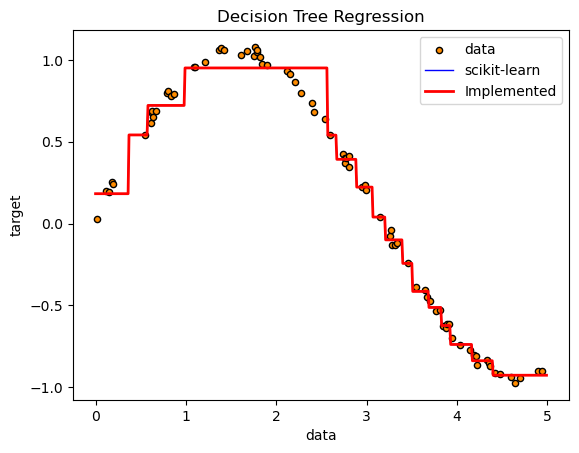

MSE for scikit-learn = 0.008218735498528891
MSE for DT_regressor = 0.00821873549852889


In [19]:
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.rand(80) * 0.1

# Make predictions
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_test = np.sin(X_test).ravel() + np.random.rand(500) * 0.1

regressor = DecisionTreeRegressor(max_depth=4, criterion='squared_error', random_state=0) 
regressor.fit(X, y)
y_pred1 = regressor.predict(X_test)

reg = DT_regressor(X, y, max_depth=4)
y_pred2 = reg.predict(X_test)

# Plot the results
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_pred1, color="blue", label="scikit-learn", linewidth=1)
plt.plot(X_test, y_pred2, color="red", label="Implemented", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

print(f'MSE for scikit-learn = {mean_squared_error(y_test, y_pred1)}')
print(f'MSE for DT_regressor = {mean_squared_error(y_test, y_pred2)}')

#### Comparison with GradientBoostingClassifier (Scikit-learn)
  - Dataset: `make_hastie_10_2`
  - Compare the classification capability of the implemented decision tree regressor `GBDTC` and the `GradientBoostingClassifier` from Scikit-learn

Accuracy for the sklearn Gradient Boosting Classifier = 0.6802
Accuracy for the implemented Gradient Boosting Classifier = 0.6802


Text(0.5, 1.0, 'Implemented Gradient Boosting Classifier')

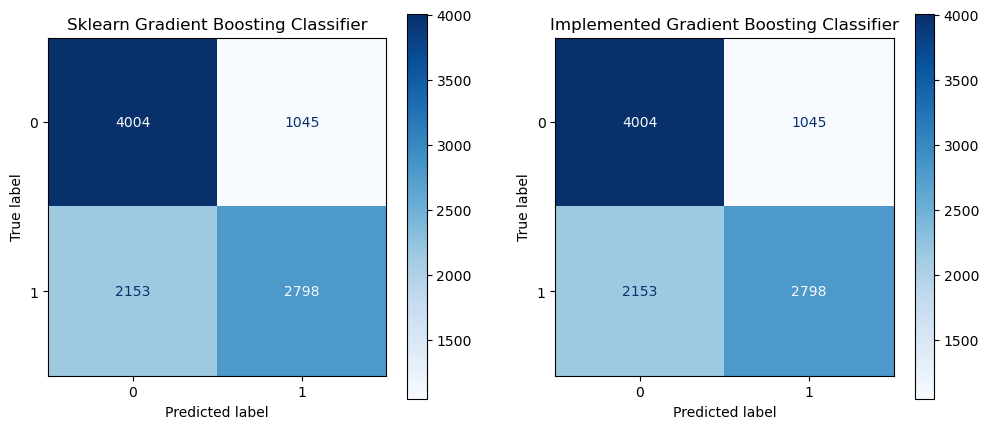

In [20]:
X, y = make_hastie_10_2(random_state=0)
X = X.astype(np.float32)
y = y.astype(np.float32)
X_train, X_test = X[:2000], X[2000:,:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=5, learning_rate=0.1, max_depth=3).fit(X_train, y_train)
    
y_pred1 = clf.predict(X_test)
accuracy1 = np.sum(y_test==y_pred1)/len(y_test)
cm1 = confusion_matrix(y_test, y_pred1)

model2 = GBDTC(n_estimators=5, learning_rate=0.1, max_depth=3)
               
model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)
accuracy2 = np.sum(y_test==y_pred2)/len(y_test)
cm2 = confusion_matrix(y_test, y_pred2)

print(f'Accuracy for the sklearn Gradient Boosting Classifier = {accuracy1}')
print(f'Accuracy for the implemented Gradient Boosting Classifier = {accuracy2}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot confusion matrix for Model 1
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(ax=axes[0], cmap='Blues')  # Plot on first axis
axes[0].set_title("Sklearn Gradient Boosting Classifier")

# Plot confusion matrix for Model 2
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(ax=axes[1], cmap='Blues')  # Plot on second axis
axes[1].set_title("Implemented Gradient Boosting Classifier")

### References

[1] Friedman, J.H., 2001. Greedy function approximation: A gradient boosting machine. Annals of Statistics, pp. 1189–1232.

[2] Scikit-learn, 2024. sklearn.ensemble.GradientBoostingClassifier. [online] Available at: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html [Accessed: 2024-12-15].

[3] Hastie, T., Tibshirani, R. and Friedman, J., 2009. The Elements of Statistical Learning. 2nd ed. Springer.

[4] Ye, A., 2020. XGBoost, LightGBM, and Other Kaggle Competition Favorites: An Intuitive Explanation and Exploration. Analytics Vidhya, [online] 27 Sep. Available at: [https://medium.com/analytics-vidhya/xgboost-lightgbm-and-other-kaggle-competition-favorites-6212e8b0e835] [Accessed: 2024-12-15].

[5] Ke, G., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., Ye, Q., & Liu, T.-Y., 2017. LightGBM: A Highly Efficient Gradient Boosting Decision Tree. Microsoft Research, Peking University, and Microsoft Redmond. Available at: [https://dl.acm.org/doi/10.5555/3294996.3295074] [Accessed: 2024-12-15].

[6] Si, S., Zhang, H., Keerthi, S.S., Mahajan, D., Dhillon, I.S. and Hsieh, C.-J., Gradient Boosted Decision Trees for High Dimensional Sparse Output. [https://dl.acm.org/doi/10.5555/3305890.3306010] [Accessed: 2024-12-15].